### Cleaning the Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


In [2]:
df = pd.read_csv('data/bankloan.csv')

In [3]:
# Drop ID and ZipCode (not useful for prediction)
df.drop(['ID', 'ZIP.Code'], axis=1, inplace=True)

In [4]:
# Features and Target
X = df.drop('Personal.Loan', axis=1)
y = df['Personal.Loan']

In [5]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Save the fitted scaler - to use for streamlit UI
import joblib
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

In [7]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
print("Data is ready.")
print("X_train shape:", X_train.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))

Data is ready.
X_train shape: (4000, 11)
y_train distribution:
 Personal.Loan
0    0.904
1    0.096
Name: proportion, dtype: float64


### Building Model with Keras

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [10]:
# Class weight works only with numpy arrays
y_train = y_train.to_numpy()


In [11]:
# Compute class weights to handle imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Properly map weights to actual class labels
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 0.5530973451327433, 1: 5.208333333333333}


In [12]:
# Build the model
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [14]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/20


2025-05-22 20:27:51.531770: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


100/100 [==============================] - 1s 3ms/step - loss: 0.5372 - accuracy: 0.5766 - auc: 0.8525 - val_loss: 0.3794 - val_accuracy: 0.8788 - val_auc: 0.9544
Epoch 2/20
100/100 [==============================] - 0s 1ms/step - loss: 0.3248 - accuracy: 0.8712 - auc: 0.9450 - val_loss: 0.2425 - val_accuracy: 0.9087 - val_auc: 0.9664
Epoch 3/20
100/100 [==============================] - 0s 1ms/step - loss: 0.2595 - accuracy: 0.9025 - auc: 0.9612 - val_loss: 0.2044 - val_accuracy: 0.9175 - val_auc: 0.9717
Epoch 4/20
100/100 [==============================] - 0s 1ms/step - loss: 0.2271 - accuracy: 0.9137 - auc: 0.9702 - val_loss: 0.1705 - val_accuracy: 0.9212 - val_auc: 0.9766
Epoch 5/20
100/100 [==============================] - 0s 1ms/step - loss: 0.2074 - accuracy: 0.9200 - auc: 0.9747 - val_loss: 0.1643 - val_accuracy: 0.9287 - val_auc: 0.9784
Epoch 6/20
100/100 [==============================] - 0s 1ms/step - loss: 0.1906 - accuracy: 0.9287 - auc: 0.9788 - val_loss: 0.1987 - val_ac

### Evaluating the Model

In [15]:
loss, accuracy, auc = model.evaluate(X_test, y_test.to_numpy(), verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")


Test Loss: 0.1142
Test Accuracy: 0.9590
Test AUC: 0.9930


In [16]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


32/32 [==============================] - 0s 445us/step


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       904
           1       0.71      0.98      0.82        96

    accuracy                           0.96      1000
   macro avg       0.85      0.97      0.90      1000
weighted avg       0.97      0.96      0.96      1000

[[865  39]
 [  2  94]]


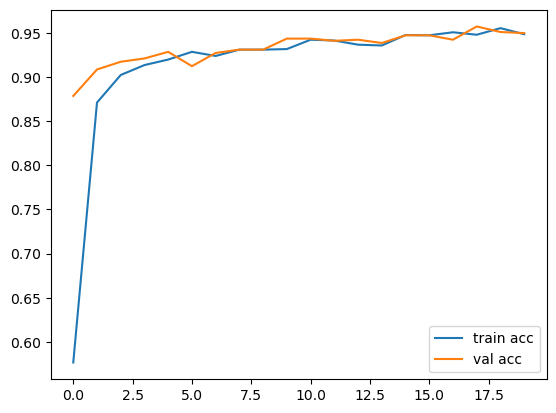

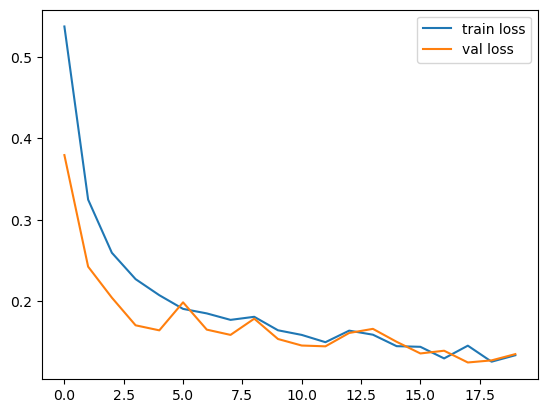

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


### Saving Model

In [19]:
model.save("bankloan_model.keras") 